In [27]:
from extract_desserts import *
from pattern.text.en import singularize
from nltk import FreqDist
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(seed=2019)


import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    datefmt='%H:%M:%S',
                   level=logging.INFO)

from time import time
import multiprocessing

In [3]:
#load the raw data
# lets use the default value that only loads 250 recipes,
# instead of 1 million
raw_data = get_raw_data()
raw_ingredients = get_raw_ingredients()

Loading file  ../data/sample_layer1.json
Loading ingredient file: ../data/sample_det_ingrs.json


In [5]:
print('N recipes: ', len(raw_data),
      '\t N list of ingredients ', 
      len(raw_ingredients))


N recipes:  20000 	 N list of ingredients  20000


In [6]:
## get a list of desserts only
desserts, dessert_ings = find_desserts(raw_data, 
                                       raw_ingredients)


In [7]:
total_recipes = len(raw_data)
dessert_recipes = len(desserts)
dessert_ingredients = len(dessert_ings)
print('Will look at {} dessert recipes, out of {} (~{:1.1f}%)'.format(
                            dessert_recipes, total_recipes,
                            dessert_recipes/total_recipes*100))

Will look at 4793 dessert recipes, out of 20000 (~24.0%)


In [12]:
item = np.random.randint(dessert_recipes)
print(item, dessert_ings[item]['valid'])
dessert_ings[item]['ingredients']

3231 [True, True, True, True, True, True, True, True, True, True, True, True, True, True]


[{'text': 'cocoa powder'},
 {'text': 'red food coloring'},
 {'text': 'vanilla extract'},
 {'text': 'butter'},
 {'text': 'sugar'},
 {'text': 'eggs'},
 {'text': 'all - purpose flour'},
 {'text': 'salt'},
 {'text': 'chocolate chips'},
 {'text': 'butter'},
 {'text': 'vanilla extract'},
 {'text': 'powdered sugar'},
 {'text': 'white chocolate'},
 {'text': 'milk'}]

# Let's look at the unique words

In [13]:
spices =['sugar','salt','water','baking soda','baking powder','flour', 'vegetable oil',
        'olive oil', 'cornstarch','nutmeg','white sugar','powdered sugar', 'brown sugar',
        'margarine','oil','shortening','kosher salt',"confectioners' sugar",'icing sugar',
        'canola oil','pepper' ,'low - fat milk','light corn syrup','cooking spray', 
         'corn syrup','vegetable shortening']

In [14]:
item=0
len(dessert_ings),len(dessert_ings[item]['ingredients'])

(4793, 5)

## Lets create a list of ingredients
And we will us it as an input to word2Vec

In [18]:
all_dingredients = []
count =0
for drecipe in dessert_ings:
    ings =[]
    for entry in drecipe['ingredients']:
        ings.append(entry['text'])
    all_dingredients.append(ings)
    count += 1
    if count%500==0:
        logging.info("read {0} ingredients".format(count))

#         break;

# print(all_dingredients)

2019-07-20 13:13:48,495 : INFO : read 500 ingredients
2019-07-20 13:13:48,499 : INFO : read 1000 ingredients
2019-07-20 13:13:48,502 : INFO : read 1500 ingredients
2019-07-20 13:13:48,504 : INFO : read 2000 ingredients
2019-07-20 13:13:48,507 : INFO : read 2500 ingredients
2019-07-20 13:13:48,509 : INFO : read 3000 ingredients
2019-07-20 13:13:48,512 : INFO : read 3500 ingredients
2019-07-20 13:13:48,515 : INFO : read 4000 ingredients
2019-07-20 13:13:48,519 : INFO : read 4500 ingredients


## Create a Word2Vec model training on the ingredients. 


In [66]:
vec_size = 100;
model = gensim.models.Word2Vec(
   # all_dingredients,
    size=vec_size,
    window=5,
    min_count=20,
    workers=10,
    alpha=0.02,
    iter=10
    )

[('ground allspice', 0.28683406114578247),
 ('miniature marshmallows', 0.2256890833377838),
 ('light brown sugar', 0.2219146341085434),
 ('vegetable oil', 0.21859200298786163),
 ('superfine sugar', 0.2021401822566986),
 ('vanilla ice cream', 0.1956455409526825),
 ('raspberries', 0.19331741333007812),
 ('slivered almonds', 0.1920645833015442),
 ('sweetened flaked coconut', 0.1851302534341812),
 ('cream of tartar', 0.18504293262958527)]

In [67]:
t = time()
model.build_vocab(all_dingredients, progress_per=1000)

2019-07-20 13:35:12,181 : INFO : collecting all words and their counts
2019-07-20 13:35:12,183 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-07-20 13:35:12,190 : INFO : PROGRESS: at sentence #1000, processed 9237 words, keeping 1669 word types
2019-07-20 13:35:12,196 : INFO : PROGRESS: at sentence #2000, processed 18232 words, keeping 2478 word types
2019-07-20 13:35:12,203 : INFO : PROGRESS: at sentence #3000, processed 27463 words, keeping 3119 word types
2019-07-20 13:35:12,208 : INFO : PROGRESS: at sentence #4000, processed 36509 words, keeping 3679 word types
2019-07-20 13:35:12,213 : INFO : collected 4078 word types from a corpus of 44027 raw words and 4793 sentences
2019-07-20 13:35:12,216 : INFO : Loading a fresh vocabulary
2019-07-20 13:35:12,225 : INFO : min_count=20 retains 272 unique words (6% of original 4078, drops 3806)
2019-07-20 13:35:12,226 : INFO : min_count=20 leaves 33941 word corpus (77% of original 44027, drops 10086)
2019-07-20 

In [68]:
model.train(all_dingredients, total_examples=model.corpus_count,
           epochs=20, report_delay=1)

2019-07-20 13:35:14,614 : INFO : training model with 10 workers on 272 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2019-07-20 13:35:14,628 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-07-20 13:35:14,636 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-07-20 13:35:14,639 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-20 13:35:14,642 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-07-20 13:35:14,648 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-07-20 13:35:14,652 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-07-20 13:35:14,654 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-20 13:35:14,655 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-20 13:35:14,655 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-20 13:35:14,656 : INFO :

2019-07-20 13:35:14,987 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-20 13:35:14,989 : INFO : EPOCH - 8 : training on 44027 raw words (17156 effective words) took 0.0s, 604056 effective words/s
2019-07-20 13:35:15,003 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-07-20 13:35:15,014 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-07-20 13:35:15,016 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-20 13:35:15,017 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-07-20 13:35:15,018 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-07-20 13:35:15,019 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-07-20 13:35:15,019 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-20 13:35:15,020 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-20 13:35:15,021 : INFO : worker thread f

2019-07-20 13:35:15,337 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-20 13:35:15,339 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-20 13:35:15,340 : INFO : EPOCH - 16 : training on 44027 raw words (17190 effective words) took 0.0s, 674508 effective words/s
2019-07-20 13:35:15,355 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-07-20 13:35:15,374 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-07-20 13:35:15,375 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-20 13:35:15,376 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-07-20 13:35:15,376 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-07-20 13:35:15,377 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-07-20 13:35:15,378 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-20 13:35:15,379 : INFO : worker thread 

(343446, 880540)

In [69]:
model.init_sims(replace=True)

2019-07-20 13:35:18,591 : INFO : precomputing L2-norms of word weight vectors


In [70]:
w1='almonds'
model.wv.most_similar(positive=w1, topn=4)

[('hazelnuts', 0.9882504940032959),
 ('almond extract', 0.9836483597755432),
 ('whipped cream', 0.9784378409385681),
 ('light corn syrup', 0.9781797528266907)]

In [71]:
w1='rum'
model.wv.most_similar(positive=['apples','banana'],
                      negative=['rum'],topn=10)

[('ginger', 0.9762071371078491),
 ('cloves', 0.9726669788360596),
 ('zucchini', 0.9680337905883789),
 ('nutmeg', 0.9537909030914307),
 ('molasses', 0.9503282904624939),
 ('raisins', 0.9488424062728882),
 ('allspice', 0.9459326863288879),
 ('cinnamon', 0.944369912147522),
 ('applesauce', 0.938673198223114),
 ('oats', 0.9307254552841187)]

In [82]:
# witem = model.wv.__getitem__(['ginger'])
# witem[0]

In [76]:
model.wv.doesnt_match(['apples','butter','banana',
                       'rum','bacon'])

'bacon'

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [144]:
def tsne_scatterplot(model, word, list_names):
    # create an array with the same size as the vector
    arrays = np.empty((0,vec_size), dtype='f')
    # set the original word,     
    word_labels = [word]
    color_list = ['red']
    # append the vector for the test word
    arrays = np.append(arrays, model.wv.__getitem__([word]),axis=0)
    
    ####### get the closest words and make then blue
    #get a list of the most similar words
    close_words = model.wv.most_similar([word])
    
    for word_score in close_words:
        # for each word get the vector  
        word_vector = model.wv.__getitem__([word_score[0]])
        # get the name
        word_labels.append(word_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, word_vector, axis=0)
     
    # get the words passed in the third entry and 
    # get those vectors, and set the color as green
    for wrd in list_names:
        word_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, word_vector, axis=0)
        
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, 
             perplexity=15).fit_transform(reduc)
    df = pd.DataFrame({'x':[x for x in Y[:, 0]],
                       'y':[y for y in Y[:,1]],
                      'words':word_labels,
                      'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(8,6)
    
    p1 = sns.regplot(data=df, 
                    x='x',y='y',fit_reg=False,
                    marker='x',
                    scatter_kws={'s':40,
                                'facecolors':df['color']})
    
    for line in range(df.shape[0]):
        p1.text(df['x'][line],df['y'][line],
               '  '+df['words'][line].title(),
               horizontalalignment='left',
                verticalalignment='bottom',size='large',
                color=df['color'][line],weight='normal'
               ).set_size(10)
        
    plt.xlim(Y[:,0].min()-50, Y[:,0].max() + 50)
    plt.ylim(Y[:,1].min()-50, Y[:,1].max() + 50)
    
    plt.title('t-SNE visualization for {}'.format(word.title()))

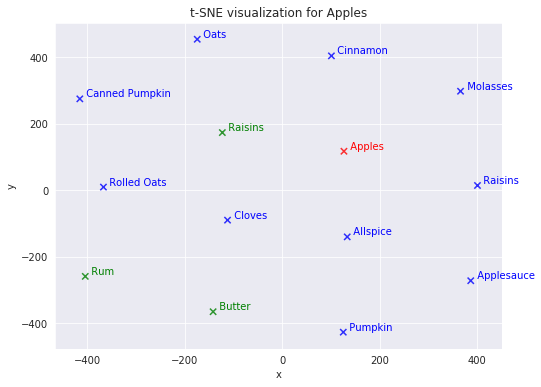

In [145]:
tsnescatterplot(model, 'apples', ['butter','rum','raisins'])

In [146]:
test_word = 'chocolate'

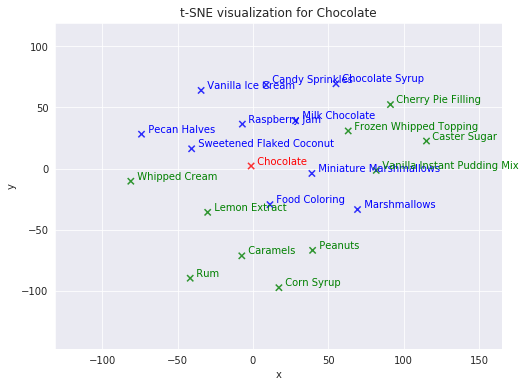

In [147]:
tsnescatterplot(model, test_word, [t[0] for t in model.wv.most_similar(positive=[test_word], topn=20)][10:])

In [15]:
# create bag of ingredients

all_ingredients = []

for recipe_ings in dessert_ings:
    n_ingredients = len(recipe_ings['valid'])
    for item, ingredient in enumerate(recipe_ings['ingredients']):
        if recipe_ings['valid'][item] ==True:
            ingred = ingredient['text'].lower()
#             ingred = singularize(ingred)
#             if ingred=='eggs':
#                 ingred='egg'
#             elif 'butter' in ingred:
#                 ingred = 'butter'
            
#             elif ingred == 'granulated sugar':
#                 ingred= 'sugar'
#             elif 'flour' in ingred:
#                 ingred = 'flour'
#             elif ingred == 'all - purpose flour' or ingred == 'cake flour':
#                 ingred = 'flour'
#             elif ingred == 'boiling water' or  ingred=='cold water':
#                 ingred = 'water'
#             elif ingred== 'light brown sugar' or ingred == 'dark brown sugar':
#                 ingred = 'sugar'
#             elif ingred == 'vanilla extract' or ingred == 'pure vanilla extract':
#                 ingred = 'vanilla'
#             elif ingred == 'fresh lemon juice':
#                 ingred = 'lemon juice'
            # find if ingredient belongs to a spice list
            an_ingredient, ingred = is_it_an_ingredient(ingred)
            if an_ingredient:
                # make it singular
                
                ingred = singularize(ingred)
                all_ingredients.append(ingred)
                
#             if ingred not in spices:
#                 all_ingredients.append(ingred)
            

In [14]:
import re

spice_list = ['sugar','salt','water','baking soda','baking powder','flour', 'oil',
         'cornstarch','sugar','margarine','shortening','pepper' ,'milk','light corn syrup','cooking spray', 
         'corn syrup', 'butter']

def is_it_an_ingredient(ingredient):
    for spice in spice_list:
        if re.search(spice, ingredient):
#             print( ingredient,' -> ingredient is a spice')
            return False, spice
#     print('Did not find ingredient in the list of spices')    
    return True, ingredient

    

In [16]:
ignore_singularize = ['nuts','molasses']

In [17]:
ingredient_set = set(all_ingredients)
print('with {} recipes, there are {} ingredients, and {} unique ingredients.'.format(
                dessert_recipes, len(all_ingredients), len(ingredient_set)))

with 4793 recipes, there are 23554 ingredients, and 2586 unique ingredients.


In [18]:
singularize('sour cream')

'sour cream'

In [19]:
fdist = FreqDist(all_ingredients)
print(fdist)

<FreqDist with 2586 samples and 23554 outcomes>


In [20]:
common = fdist.most_common(4200)

In [30]:
for c in common:
    if 'soy' in c[0]:
        print(c)
    

('soy sauce', 37)
('soy cream cheese', 2)
('soy yogurt', 2)
('dark soy sauce', 2)
('soy sour cream', 1)
('light soy sauce', 1)
('roasted soybean', 1)
('low sodium soy sauce', 1)


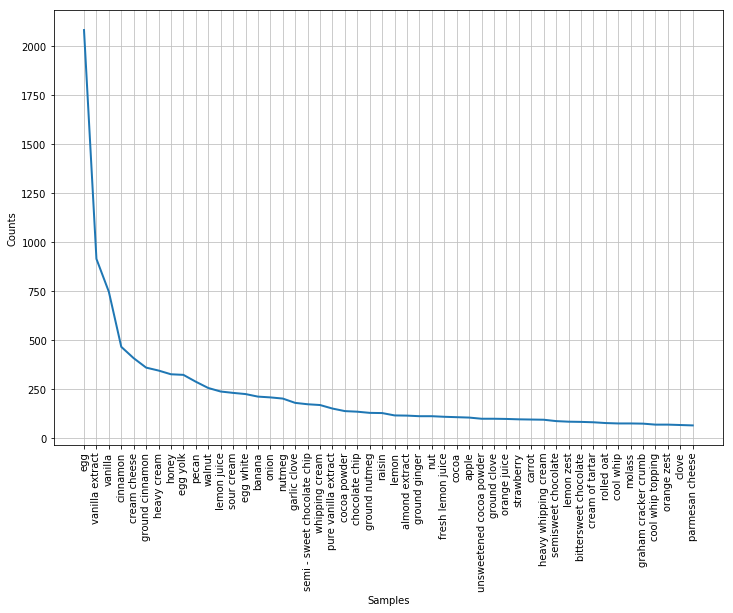

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 8))
# plt.ylim(0,120)
fdist.plot(50,cumulative=False)
# plt.ylim(0,30)
# plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
import string

from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
np.random.seed(23)

In [ ]:
stopwords_list  = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list +=

In [ ]:
stopwords_list[-20:]